In [1]:
import pandas as pd
import datetime
import numpy as np
import statsmodels.api as sm
import folium
import requests
import seaborn as sns

In [2]:
# For Graphics
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

## 

In [3]:
data = pd.read_csv('pythons.csv')

In [4]:
data.shape

(4798, 54)

In [5]:
data.columns

Index(['objectid', 'Reporter', 'ComName', 'SciName', 'OccStatus', 'ObsDate',
       'DateAcc', 'DateEnt', 'DateUp', 'Location', 'Latitude', 'Longitude',
       'Datum', 'CoordAcc', 'Method', 'DataType', 'LocalOwner', 'Habitat',
       'Locality', 'Site', 'InfestAcre', 'GrossAcre', 'Abundance', 'Density',
       'NumCollect', 'Percentcov', 'TreatArea', 'TreatComm', 'Quantity',
       'QuantityU', 'TrapType', 'NumTraps', 'Comments', 'VisitType',
       'CollectTme', 'Surveyor', 'RecSource', 'RecOwner', 'RecSrcTyp',
       'OrigName', 'Nativity', 'Host', 'Host_Name', 'VerifyMthd', 'IDCred',
       'Verified', 'Reviewer', 'ReviewDate', 'OrgSrcID', 'PID', 'Voucher',
       'Museum', 'MuseumRec', 'Reference'],
      dtype='object')

In [6]:
col_nan = list(data.columns[data.isnull().any()])
null_col = data[col_nan]
null_col.isnull().sum()

DateAcc       4793
DateUp        3614
CoordAcc      4506
Method        2695
DataType      2479
LocalOwner    4763
Habitat       4236
Locality      2296
Site          4797
InfestAcre    4681
GrossAcre     4760
Abundance     4798
Density       4798
NumCollect    1401
Percentcov    4797
TreatArea     4798
TreatComm     4798
Quantity      4687
QuantityU     4687
TrapType      4798
NumTraps      4798
Comments      2211
VisitType     2711
CollectTme    4570
Surveyor      3246
RecSource     4798
OrigName      2510
Host          4798
Host_Name     4798
VerifyMthd      70
IDCred           4
Reviewer      3922
ReviewDate    3922
OrgSrcID      4798
PID           4798
Voucher       4313
Museum        2684
MuseumRec     4225
Reference     2480
dtype: int64

In [7]:
data.dtypes

objectid        int64
Reporter       object
ComName        object
SciName        object
OccStatus      object
ObsDate        object
DateAcc       float64
DateEnt        object
DateUp         object
Location       object
Latitude      float64
Longitude     float64
Datum          object
CoordAcc      float64
Method         object
DataType       object
LocalOwner     object
Habitat        object
Locality       object
Site           object
InfestAcre    float64
GrossAcre     float64
Abundance     float64
Density       float64
NumCollect     object
Percentcov     object
TreatArea     float64
TreatComm     float64
Quantity      float64
QuantityU      object
TrapType      float64
NumTraps      float64
Comments       object
VisitType      object
CollectTme    float64
Surveyor       object
RecSource     float64
RecOwner       object
RecSrcTyp      object
OrigName       object
Nativity       object
Host          float64
Host_Name     float64
VerifyMthd     object
IDCred         object
Verified  

## Client would like to know, among other things:


### 1.  Are sightings of Burmese pythons in the wild increasing? (Client wants an analysis with visualizations)


We create a pivot tables, where the rows are years and columns, value will be counts:
* The column that we would analyise is ObsDate
* If there is Nan Value we are going to replace wit the value in DateEnt.

In [8]:
data['ObsYear'] = pd.DatetimeIndex(data['ObsDate']).year
data['ObsMonth'] = pd.DatetimeIndex(data['ObsDate']).month
data['ObsDay'] = pd.DatetimeIndex(data['ObsDate']).day

In [9]:
data_obs_date = pd.pivot_table(
    data,
    index = ['ObsYear','ObsMonth'],
    values = 'objectid',
    aggfunc = len
)
obs_date_pivot = data_obs_date.reset_index().sort_values(by = ['ObsYear','ObsMonth'], ascending = True)

In [10]:
obs_date_pivot.head(10)
obs_date_pivot['Obs_Year-Month'] = pd.to_datetime(obs_date_pivot['ObsYear'].astype(str)  + obs_date_pivot['ObsMonth'].astype(str), format='%Y%m')
obs_date_pivot.head(10)

,ObsYear,ObsMonth,objectid,Obs_Year-Month
0,1979,10,1,1979-10-01
1,1995,12,1,1995-12-01
2,1996,2,1,1996-02-01
3,1996,11,1,1996-11-01
4,1997,11,4,1997-11-01
5,1998,5,1,1998-05-01
6,1998,8,1,1998-08-01
7,1999,2,2,1999-02-01
8,1999,12,1,1999-12-01
9,2000,1,2,2000-01-01


/usr/local/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Number of sightings')

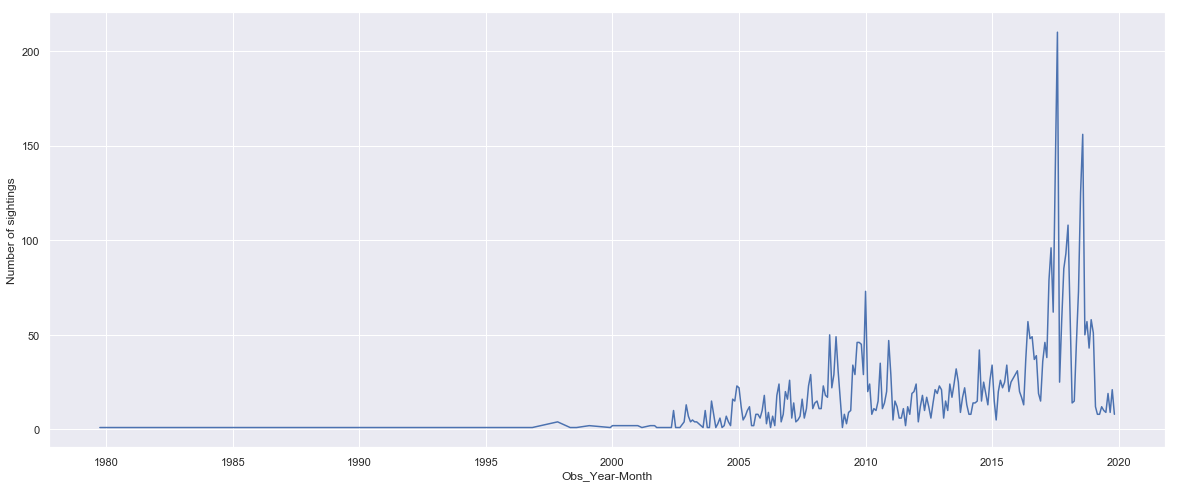

In [11]:
plt.figure(figsize=(20,8))
obs_date = sns.lineplot(x='Obs_Year-Month', y = 'objectid', data=obs_date_pivot, color="b")
obs_date.set_xlabel('Obs_Year-Month')
obs_date.set_ylabel("Number of sightings")

There is a tendecy that the seens have been growing, at the end there is a reduction it could be because there is recent data so there is less inputs

## 2. Which three counties are most affected? (Analysis + visualization)

In [12]:
counties_count = data['Location'].value_counts().rename_axis('Counties').reset_index(name='Counts')
counties = counties_count['Counties'].str.split(',', expand=True)[0]
counties_count = counties_count[['Counts']]
counties_count['Counties'] = counties
counties_count[['Counties', 'Counts']].head(3)

,Counties,Counts
0,Miami-Dade,3536
1,Collier,486
2,Monroe,365


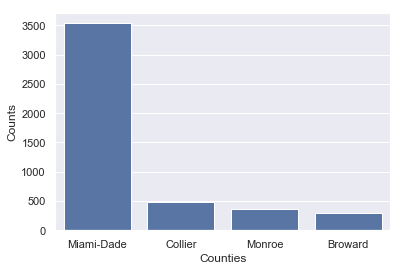

In [13]:
sns.barplot(x='Counties', y='Counts', data=counties_count[['Counties', 'Counts']].head(4),
            label="Total", color="b")

# 3. Are there geographic hotspots? If so, can you estimate the likelihood that volunteers would find pythons if we sent patrols to those areas between today's date and Dec 31st? (Analysis + viz)

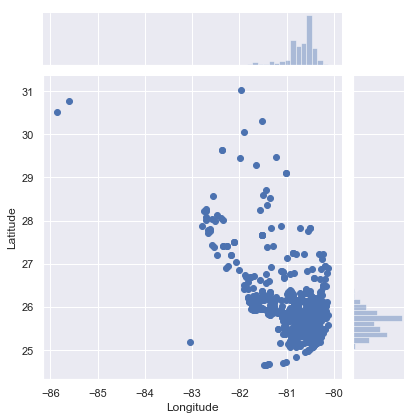

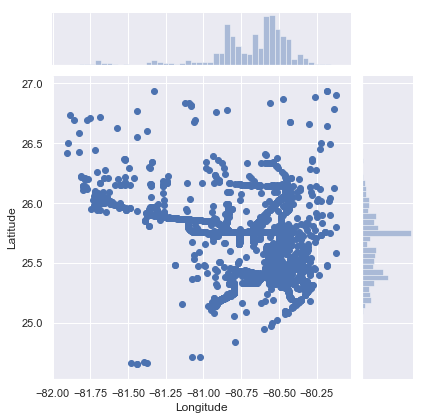

In [64]:
coordinates = pd.DataFrame(data[['Latitude', 'Longitude']])

values = pd.DataFrame(coordinates.loc[(coordinates['Latitude'] < 32.5) & (coordinates['Longitude'] < -50)])  #coordinates.loc[coordinates['Longitude'] < -50]

sns.jointplot(x="Longitude", y="Latitude", data=values);

closest = pd.DataFrame(coordinates.loc[(coordinates['Latitude'] < 27) & (coordinates['Longitude'] < -26.5) & (coordinates['Longitude'] > -82)])

sns.jointplot(x="Longitude", y="Latitude", data=closest);

In [65]:
sight = closest.groupby(['Latitude','Longitude']).count().reset_index()
map1 = folium.Map(
    location=[43.12627,-77.53985],
    tiles='cartodbpositron',
    zoom_start=2,
)
sight.apply(lambda row:folium.CircleMarker(location=[row["Latitude"], row["Longitude"]]).add_to(map1), axis=1)
map1

### 4. When are people most likely to spot pythons, and why? (Analysis + viz)

In [16]:
data_obs_year = pd.pivot_table(
    data,
    index = ['ObsYear'],
    values = 'objectid',
    aggfunc = len
)
obs_year_pivot = data_obs_year.reset_index().sort_values(by = 'objectid', ascending = False)

In [17]:
top_years = list(set(obs_year_pivot['ObsYear'].head(8)))
top_years

[2016, 2017, 2018, 2008, 2009, 2010, 2013, 2015]

In [18]:
top_years_data = data[data.ObsYear.isin(top_years)]
top_years_data.head()

,objectid,Reporter,ComName,SciName,OccStatus,ObsDate,DateAcc,DateEnt,DateUp,Location,...,ReviewDate,OrgSrcID,PID,Voucher,Museum,MuseumRec,Reference,ObsYear,ObsMonth,ObsDay
40,8275470,"matthew mccollister National Park Service, Big...",Burmese python,Python molurus ssp. bivittatus,Positive,13 Aug 2018,NaN,27 Sep 2019,27 Sep 2019,"Miami-Dade, Florida, United States",...,27 Sep 2019,NaN,NaN,NaN,NaN,NaN,NaN,2018,8,13
62,8251562,FWCC Exotic Species Database Florida Fish and ...,Burmese python,Python molurus ssp. bivittatus,Treated,27 May 2017,NaN,03 Aug 2019,NaN,"Miami-Dade, Florida, United States",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017,5,27
63,8251561,FWCC Exotic Species Database Florida Fish and ...,Burmese python,Python molurus ssp. bivittatus,Treated,15 May 2017,NaN,03 Aug 2019,NaN,"Miami-Dade, Florida, United States",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017,5,15
64,8251560,FWCC Exotic Species Database Florida Fish and ...,Burmese python,Python molurus ssp. bivittatus,Treated,10 May 2017,NaN,03 Aug 2019,NaN,"Miami-Dade, Florida, United States",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017,5,10
65,8251559,FWCC Exotic Species Database Florida Fish and ...,Burmese python,Python molurus ssp. bivittatus,Treated,07 May 2017,NaN,03 Aug 2019,NaN,"Miami-Dade, Florida, United States",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017,5,7


In [19]:
data_month_topyears = pd.pivot_table(
    top_years_data,
    index = ['ObsMonth'],
    columns = ['ObsYear'],
    values = ['objectid'],
    aggfunc = 'count',
    margins = True
)

data_month_topyears.columns = data_month_topyears.columns.droplevel(0) # We got multiindex, we dropped one level
print(data_month_topyears)
data_month_topyears = data_month_topyears.head(12)
data_month_topyears

ObsYear   2008  2009  2010  2013  2015  2016  2017  2018   All
ObsMonth                                                      
1           14    16    73    21    34    31    36   108   333
2           15     1    20     6    15    20    46    58   181
3           11     8    24    15     5    17    38    14   132
4           11     3     8    10    20    13    79    15   159
5           23     9    11    24    26    37    96    45   271
6           18    10    10    17    22    57    62    73   269
7           17    34    15    24    25    48   137   125   425
8           50    29    35    32    34    49   210   156   595
9           22    46    11    25    20    37    25    50   236
10          29    46    14     9    25    39    57    57   276
11          49    45    20    17    27    19    85    43   305
12          31    29    47    22    29    15    93    58   324
All        290   276   288   222   282   382   964   802  3506


ObsYear,2008,2009,2010,2013,2015,2016,2017,2018,All
ObsMonth,,,,,,,,,
1,14,16,73,21,34,31,36,108,333
2,15,1,20,6,15,20,46,58,181
3,11,8,24,15,5,17,38,14,132
4,11,3,8,10,20,13,79,15,159
5,23,9,11,24,26,37,96,45,271
6,18,10,10,17,22,57,62,73,269
7,17,34,15,24,25,48,137,125,425
8,50,29,35,32,34,49,210,156,595
9,22,46,11,25,20,37,25,50,236


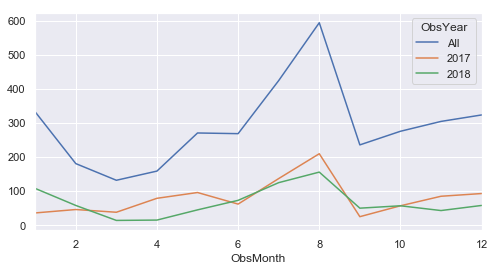

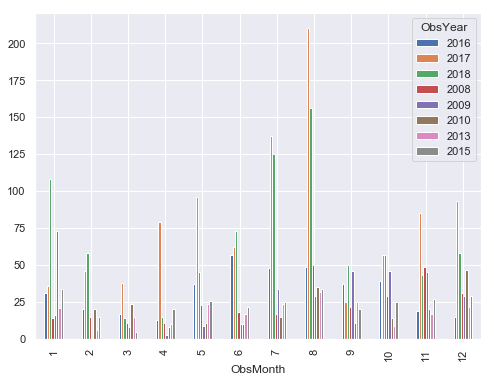

In [20]:
data_month_topyears.plot(kind = 'line', figsize=(8, 4), y = ['All',2017,2018])
data_month_topyears[top_years].plot(kind = 'bar', figsize=(8, 6))

During the years we can observe that the month of August and July we can seen more burmese python, then jump to the winter month.
There is a rare tendency, so we start selecting the data by year:, 
* All Data.
* Top 10 years.
* Top 5 years.
* 2017 (Year with more sights)
* 2018 (2nd Year with more sights)

https://myfwc.com/wildlifehabitats/nonnatives/python/faqs/


During `warm months` they like to stay in the water, but they are more active at night; most pythons are found crossing roads during late hours.

`During cooler months` you can find them outside the water; they move away from the vegetation edges later on the day.

`February, March, April` these are the breeding month, they stay close to the nest and water edges.


So yes, there you can see that there is a seasonal tendecy that is why you can find more during the warm and cooler months.

### 5. Are sightings cyclical? (Analysis + viz)

We are going to analyse [20`5 - 2018] period

In [21]:
cyclical_analysis = data[data.ObsYear.isin(list(range(2008, 2020)))]
cyclical_analysis.head()

,objectid,Reporter,ComName,SciName,OccStatus,ObsDate,DateAcc,DateEnt,DateUp,Location,...,ReviewDate,OrgSrcID,PID,Voucher,Museum,MuseumRec,Reference,ObsYear,ObsMonth,ObsDay
0,8303498,Travis Mangione FWC,Burmese python,Python molurus ssp. bivittatus,Positive,24 Nov 2019,NaN,26 Nov 2019,NaN,"Miami-Dade, Florida, United States",...,05 Dec 2019,NaN,NaN,0.0,NaN,NaN,NaN,2019,11,24
1,8303147,Edward F. Metzger III,Burmese python,Python molurus ssp. bivittatus,Positive,20 Nov 2019,NaN,22 Nov 2019,22 Nov 2019,"Broward, Florida, United States",...,05 Dec 2019,NaN,NaN,NaN,NaN,NaN,NaN,2019,11,20
2,8298008,Michael Reupert NPS Big Cypress National Pres...,Burmese python,Python molurus ssp. bivittatus,Positive,07 Nov 2019,NaN,12 Nov 2019,NaN,"Collier, Florida, United States",...,14 Nov 2019,NaN,NaN,0.0,HQ freezer ...,NaN,NaN,2019,11,7
3,8295649,"matthew mccollister National Park Service, Big...",Burmese python,Python molurus ssp. bivittatus,Positive,06 Nov 2019,NaN,07 Nov 2019,NaN,"Collier, Florida, United States",...,08 Nov 2019,NaN,NaN,0.0,NaN,NaN,NaN,2019,11,6
4,8295647,"matthew mccollister National Park Service, Big...",Burmese python,Python molurus ssp. bivittatus,Positive,05 Nov 2019,NaN,07 Nov 2019,NaN,"Collier, Florida, United States",...,08 Nov 2019,NaN,NaN,0.0,NaN,NaN,NaN,2019,11,5


In [22]:
print(cyclical_analysis.shape)

cyclical_analysis['datetime'] = pd.to_datetime(cyclical_analysis['ObsDate'])
cyclical_analysis = cyclical_analysis.set_index('datetime')
cyclical_analysis.drop(['ObsDate'], axis=1, inplace=True)
print(cyclical_analysis.shape)

(4210, 57)
(4210, 56)


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [23]:
test = cyclical_analysis.groupby('datetime')[['objectid']].count()
test.head(20)

,objectid
datetime,
2008-01-10,1
2008-01-12,1
2008-01-13,1
2008-01-14,1
2008-01-15,1
2008-01-16,4
2008-01-17,1
2008-01-18,1
2008-01-20,1


In [24]:
a = test.resample('14D').count()
a.head(20)

,objectid
datetime,
2008-01-10,9
2008-01-24,5
2008-02-07,4
2008-02-21,4
2008-03-06,3
2008-03-20,4
2008-04-03,2
2008-04-17,5
2008-05-01,7


In [25]:
a = a.replace(0, None)

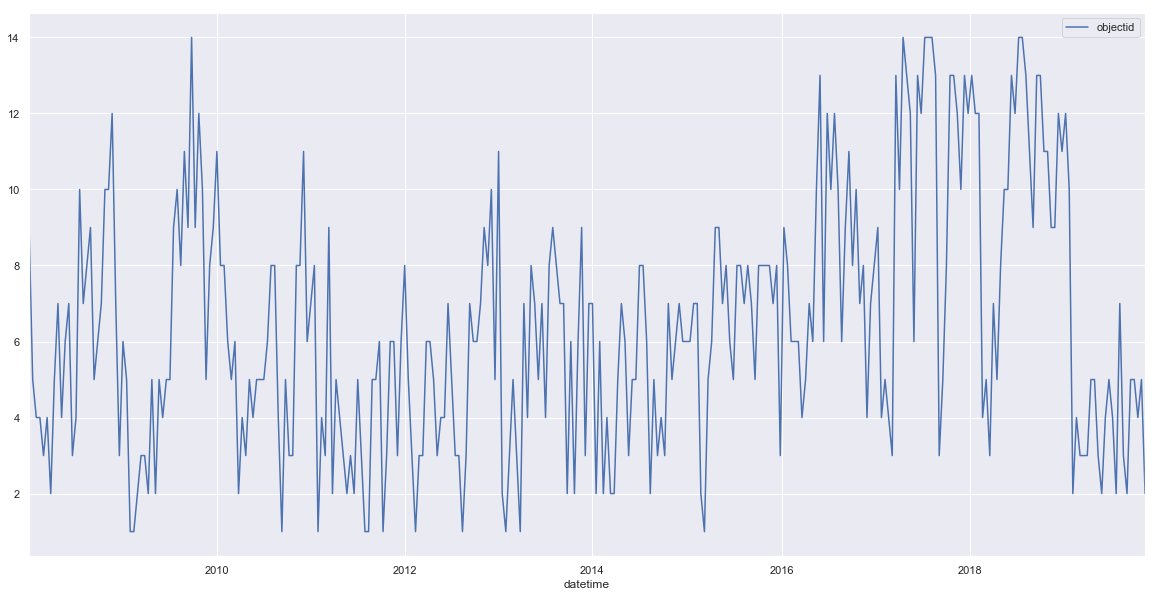

In [26]:
a.reset_index().plot(x='datetime', y='objectid', figsize =(20,10))

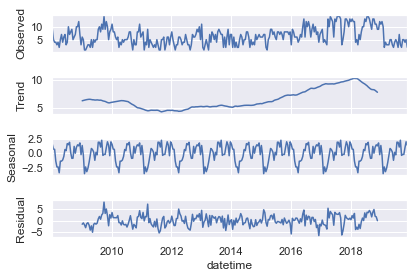

In [27]:
from statsmodels.tsa.seasonal import seasonal_decompose

_ = seasonal_decompose(a).plot()

Definetly the sigts are cyclical between the month; but yearly there is a trend, increasing from 2014 to 2017 when it reach its plateau, being lower 2018 and 2019.

### 6. How many python observations do you predict will be recorded for the full 2019 year? (time-series analysis)

In [28]:
b = a['objectid']

In [29]:
train = b[:-23]
test = b[-23:]

print(train.head(), test.head())
#Starting on 2008

datetime
2008-01-10    9
2008-01-24    5
2008-02-07    4
2008-02-21    4
2008-03-06    3
Freq: 14D, Name: objectid, dtype: int64 datetime
2019-01-10    12
2019-01-24    10
2019-02-07     2
2019-02-21     4
2019-03-07     3
Freq: 14D, Name: objectid, dtype: int64


In [30]:
from statsmodels.tsa.arima_model import ARMA

model = ARMA(
    train,
    order = (2,1) 
).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:               objectid   No. Observations:                  287
Model:                     ARMA(2, 1)   Log Likelihood                -671.693
Method:                       css-mle   S.D. of innovations              2.510
Date:                Thu, 12 Dec 2019   AIC                           1353.386
Time:                        22:52:54   BIC                           1371.684
Sample:                    01-10-2008   HQIC                          1360.720
                         - 12-27-2018                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              6.6453      0.534     12.438      0.000       5.598       7.692
ar.L1.objectid     0.5782      0.335      1.724      0.086      -0.079       1.235
ar.L2.objectid     0.1770      0.220      0.803      0.423      -0.255       0.609
ma.L1.objectid    -0.1069      0.345     -0.309      0.757      -0.784       0.570
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.2506           +0.0000j            1.2506            0.0000
AR.2           -4.5168           +0.0000j            4.5168            0.5000
MA.1            9.3532           +0.0000j            9.3532            0.0000
-----------------------------------------------------------------------------
"""

In [31]:
predictions = model.predict(
    start = len(train),
    end = len(train) + len(test) -1
)

obs_pre = pd.DataFrame({
    'observed' : test,
    'predicted' : predictions
})
obs_pre

,observed,predicted
datetime,,
2019-01-10,12,9.980170
2019-01-24,10,9.344482
2019-02-07,2,8.796376
2019-02-21,4,8.366916
2019-03-07,3,8.021564
2019-03-21,3,7.745847
2019-04-04,3,7.525285
2019-04-18,5,7.348943
2019-05-02,5,7.207932


In [32]:
from statsmodels.tools.eval_measures import rmse

rmse(test, predictions)

3.6546915384597845

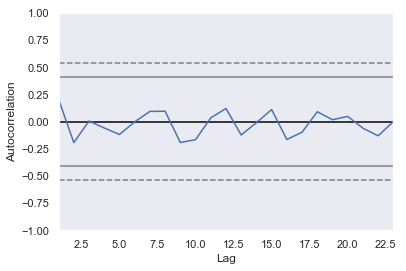

In [33]:
pd.plotting.autocorrelation_plot(test)

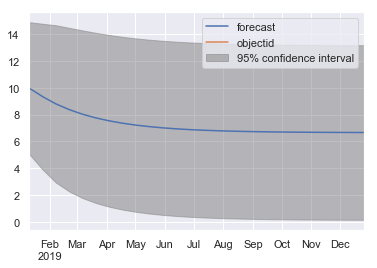

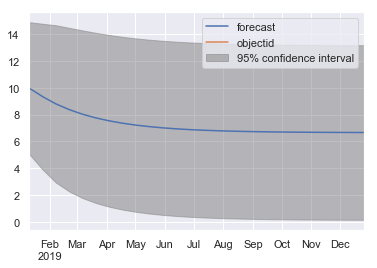

In [34]:
model.plot_predict(
    start = len(train),
    end = len(train) + len(test) +2
)

In [35]:
prediction2019 = predictions = model.predict(
    start = len(train),
    end = len(train) + len(test)+2
)
prediction2019.sum().round()

190.0

In [36]:
obs_pre.sum().round()

observed     100.0
predicted    170.0
dtype: float64

# iNaturalist

In [37]:
url = "https://api.inaturalist.org/v1/observations?verifiable=true&order_by=observations.id&order=desc&spam=false&place_id=21&taxon_id=238252&locale=en-US&per_page=100"
response = requests.get(url)
results = response.json()

In [38]:
inaturalist = pd.DataFrame(results)
inaturalist.head(10)

,total_results,page,per_page,results
0,82,1,100,"{'out_of_range': True, 'quality_grade': 'resea..."
1,82,1,100,"{'out_of_range': True, 'quality_grade': 'resea..."
2,82,1,100,"{'out_of_range': True, 'quality_grade': 'resea..."
3,82,1,100,"{'out_of_range': True, 'quality_grade': 'resea..."
4,82,1,100,"{'out_of_range': True, 'quality_grade': 'resea..."
5,82,1,100,"{'out_of_range': True, 'quality_grade': 'resea..."
6,82,1,100,"{'out_of_range': True, 'quality_grade': 'resea..."
7,82,1,100,"{'out_of_range': True, 'quality_grade': 'resea..."
8,82,1,100,"{'out_of_range': True, 'quality_grade': 'resea..."
9,82,1,100,"{'out_of_range': True, 'quality_grade': 'resea..."


In [39]:
from pandas.io.json import json_normalize
flattened_data = json_normalize(inaturalist['results'])
flattened_data

,annotations,cached_votes_total,captive,comments,comments_count,community_taxon_id,context_geoprivacy,context_taxon_geoprivacy,context_user_geoprivacy,created_at,...,user.name_autocomplete,user.observations_count,user.orcid,user.roles,user.site_id,user.spam,user.suspended,user.universal_search_rank,uuid,votes
0,[],0,False,[],0,238252,None,None,None,2019-11-28T11:42:31-05:00,...,None,12,None,[],1.0,False,False,12,c20ce707-7ce3-4be0-9916-19ccf70cb286,[]
1,[],0,False,[],0,238252,None,None,None,2019-11-28T11:37:28-05:00,...,None,12,None,[],1.0,False,False,12,128ce356-3aeb-40ef-8caa-b394e163b965,[]
2,[],1,False,"[{'moderator_actions': [], 'hidden': False, 'f...",3,238252,None,None,None,2019-11-11T16:55:45-05:00,...,None,12,None,[],1.0,False,False,12,0131e350-538e-4ee2-be4a-dc0f8836677d,"[{'vote_flag': True, 'user_id': 2201722, 'crea..."
3,[],0,False,"[{'moderator_actions': [], 'hidden': False, 'f...",4,238252,None,None,None,2019-11-05T20:33:57-05:00,...,Wayne Fidler,6514,None,[],1.0,False,False,6514,0b4a2d5b-af68-4604-a957-e9bf6a08f0e9,[]
4,[],0,False,[],0,238252,None,None,None,2019-11-05T08:17:21-05:00,...,Wayne Fidler,6514,None,[],1.0,False,False,6514,16942dca-b916-47c9-b730-79397e53d338,[]
5,[],0,False,"[{'moderator_actions': [], 'hidden': False, 'f...",1,238252,None,None,None,2019-11-05T01:04:51-05:00,...,Wayne Fidler,6514,None,[],1.0,False,False,6514,992a63f9-13c1-4988-bec6-91af9446efa3,[]
6,[],0,False,[],0,238252,None,None,None,2019-11-04T22:47:23-06:00,...,J.D. Willson,2345,None,[],1.0,False,False,2345,b326f151-051e-4700-8787-10fa69ba7885,[]
7,[],0,False,[],0,238252,None,None,None,2019-10-31T23:05:35-04:00,...,None,306,None,[],1.0,False,False,306,6d6af57c-1e72-444f-8f76-270f053dc739,[]
8,[],0,False,[],0,238252,None,None,None,2019-10-31T23:04:27-04:00,...,None,306,None,[],1.0,False,False,306,e0fdd939-219d-450b-a093-a7b278749719,[]
9,[],0,False,[],0,238252,None,None,None,2019-10-27T17:14:58-04:00,...,None,306,None,[],1.0,False,False,306,f04c7df0-696c-45d2-91d0-64626d60b526,[]


In [40]:
#Should we be using iNaturalist to get the public more engaged? (Back your answer with data)
flattened_data.shape[0]
#Since we have only 82 observation, 
#so we Should we be using iNaturalist to get the public more engaged? 

82

In [41]:
users = pd.pivot_table(
    data =  flattened_data,
    index='user.login',
    values= 'id',
    aggfunc=len
)
top_active_users = users.reset_index().sort_values(by = 'id', ascending = False).head(5)
top_active_users

,user.login,id
34,pythonbob,12
22,joemdo,6
3,atrox77,4
28,michiko,4
38,snakesareprettycool,3


Text(0, 0.5, 'Users')

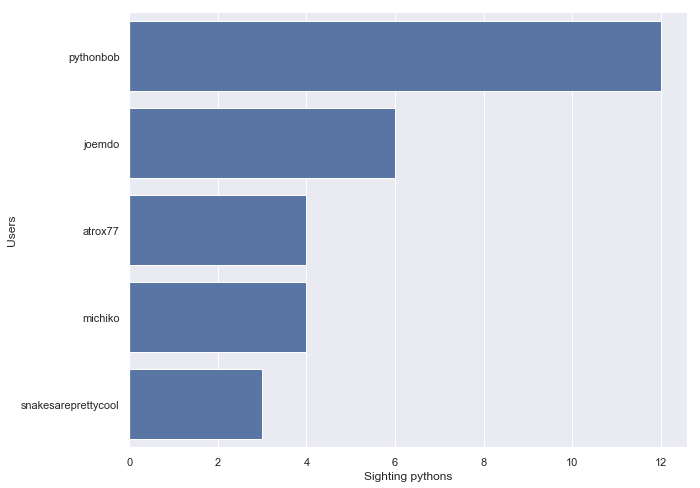

In [42]:

plt.figure(figsize=(10,8))
ax = sns.barplot(x="id", y="user.login", data=top_active_users, color="b")
ax.set_xlabel("Sighting pythons")
ax.set_ylabel("Users")

In [43]:
list(flattened_data.columns)
obs = flattened_data[['id', 'reviewed_by', 'quality_grade']]
obs.head()

,id,reviewed_by,quality_grade
0,36162544,"[769610, 971085, 2320836]",research
1,36162417,"[268311, 971085, 2008097, 2320836]",research
2,35585367,"[268311, 971085, 2320836]",research
3,35350568,"[281081, 324885, 769610, 971085, 1737389]",research
4,35324661,"[63043, 151498, 281081, 324885, 971085]",research


In [44]:
dfToList = obs['reviewed_by'].tolist()
flat_list = []
for sublist in dfToList:
    for item in sublist:
        flat_list.append(item)
flat_list

[769610,
 971085,
 2320836,
 268311,
 971085,
 2008097,
 2320836,
 268311,
 971085,
 2320836,
 281081,
 324885,
 769610,
 971085,
 1737389,
 63043,
 151498,
 281081,
 324885,
 971085,
 64372,
 85164,
 281081,
 769610,
 1064292,
 1737389,
 268311,
 324885,
 971085,
 1220380,
 7757,
 268311,
 971085,
 1484946,
 7757,
 971085,
 1484946,
 63043,
 268311,
 971085,
 1484946,
 1668849,
 43772,
 268311,
 324885,
 971085,
 1230674,
 2061694,
 268311,
 324885,
 411512,
 971085,
 3376,
 268311,
 365249,
 971085,
 1863276,
 27034,
 268311,
 740297,
 741608,
 947744,
 971085,
 25150,
 268311,
 324885,
 947744,
 971085,
 2143540,
 63043,
 268311,
 947744,
 971085,
 1926697,
 320048,
 741608,
 947744,
 971085,
 1737389,
 27034,
 268311,
 947744,
 971085,
 1737389,
 1863276,
 268311,
 583493,
 943403,
 947744,
 971085,
 1568995,
 268311,
 769610,
 947744,
 971085,
 1484946,
 1568995,
 268311,
 769610,
 947744,
 1484946,
 268311,
 349183,
 769610,
 947744,
 971085,
 1212962,
 268311,
 349183,
 769610,


In [45]:
pd.DataFrame(flat_list)[0].value_counts().head(5)

947744    65
458167    40
971085    38
769610    32
268311    29
Name: 0, dtype: int64

In [46]:
list(flattened_data.columns)

['annotations',
 'cached_votes_total',
 'captive',
 'comments',
 'comments_count',
 'community_taxon_id',
 'context_geoprivacy',
 'context_taxon_geoprivacy',
 'context_user_geoprivacy',
 'created_at',
 'created_at_details.date',
 'created_at_details.day',
 'created_at_details.hour',
 'created_at_details.month',
 'created_at_details.week',
 'created_at_details.year',
 'created_time_zone',
 'description',
 'faves',
 'faves_count',
 'flags',
 'geojson.coordinates',
 'geojson.type',
 'geoprivacy',
 'id',
 'id_please',
 'ident_taxon_ids',
 'identifications',
 'identifications_count',
 'identifications_most_agree',
 'identifications_most_disagree',
 'identifications_some_agree',
 'license_code',
 'location',
 'map_scale',
 'mappable',
 'non_owner_ids',
 'num_identification_agreements',
 'num_identification_disagreements',
 'oauth_application_id',
 'obscured',
 'observation_photos',
 'observed_on',
 'observed_on_details.date',
 'observed_on_details.day',
 'observed_on_details.hour',
 'observe